In [51]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common


import abc

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [52]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score

import plotly.offline as pyo
import plotly.graph_objs as go

import re

from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm

import warnings
warnings.filterwarnings(action='ignore') 

In [4]:
# 캐글 데이터
df = pd.read_csv('G://내 드라이브/Github/Predictiong_MBTI_for_Internet_Users/MBTI 500.csv', encoding='ISO-8859-1')

In [5]:
df.columns = ['text', 'type']
df = df[['type', 'text']]

In [6]:
#function to clean the text data
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.text):
        sentence=sentence.lower()
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

df.text, _=clear_text(df)

100%|████████████████████████████████████████████████████████████████████████| 106067/106067 [00:20<00:00, 5217.16it/s]


In [7]:
X = df['text'] # features
y = df['type']  # labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [8]:
# Pipelining the vectorizer and the classifier
text_clf1 = Pipeline([('tfidf',TfidfVectorizer(sublinear_tf = True)),('clf',LinearSVC())])

In [9]:
text_clf1.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('clf', LinearSVC())])

In [10]:
predictions1 = text_clf1.predict(X_val)

+++

In [11]:
tf.version.VERSION

'2.9.0'

### 하이퍼 파라미터 설정

In [193]:
num_iterations = 4 # @param {type:"integer"}

initial_collect_steps = 2  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 2  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 2# @param {type:"integer"}
eval_interval = 2  # @param {type:"integer"}

In [94]:
# challenge

In [196]:
returns = list()

class LinegameEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=100, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
        self._state = 0.1
        self._time = 1
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0.1
        self._time = 1
        self._episode_ended = False
        return ts.restart(np.array([self._state], dtype=np.int32))

    def _step(self, action):
        if self._episode_ended:
            self.reset()
        elif self._time==1: 
            print("### new episode start! ###")
            print(" ")
        else: 
            print(" ")
        
        print("{}-1. current state = {}".format(self._time,self._state))
        
        # Pipelining the vectorizer and the classifier
        text_clf1 = Pipeline([('tfidf',TfidfVectorizer(sublinear_tf = True)),('clf',LinearSVC(C= self._state))])
        text_clf1.fit(X_train, y_train)
        
        reward = metrics.accuracy_score(y_val, text_clf1.predict(X_val))
        
        #self._state += (action-500)/500
        #print("{}-2. action = {}".format(self._time,(action-500)/500))
        self._state += (action-50)/500
        print("{}-2. action = {}".format(self._time,(action-50)/500))
        
        
        if self._state < 0.1:
          print("    **exit(current state<0.1) => reset current state as 0.**")
          self._state = 0.1
        if self._state > 1.0 : 
          print("   **exit(current state >1.0) => reset current state as 1.**")
          self._state = 1.0
        
        print("{}-3. reward = {}".format(self._time,reward))
        returns.append(reward) ############################# !!!
        
        print("{}-4. future state = {}".format(self._time,self._state))
        
        self._time += 1
        if self._time > 4: self._episode_ended = True
        
        if self._episode_ended:
            print(" ")
            print("### episode ended ###")
            return ts.termination(np.array([self._state], dtype=np.int32), reward)
        else:
            return ts.transition(np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)

In [195]:
environment = LinegameEnv()
utils.validate_py_environment(environment, episodes=1)

### new episode start! ###
 
1-1. current state = 1.0


KeyboardInterrupt: 

In [182]:
returns

[0.8440652399358914,
 0.8440652399358914,
 0.8440652399358914,
 0.844442349391911,
 0.8448194588479306,
 0.8451965683039502,
 0.8460450645799943,
 0.8459507872159895,
 0.8466107287640238,
 0.8462336193080041,
 0.846327896672009,
 0.8459507872159895,
 0.8457622324879797,
 0.8452908456679551,
 0.8456679551239747,
 0.8451965683039502,
 0.8451965683039502,
 0.8459507872159895,
 0.8459507872159895,
 0.8451965683039502,
 0.8461393419439992,
 0.8460450645799943,
 0.8460450645799943,
 0.8457622324879797,
 0.8451022909399453,
 0.8459507872159895,
 0.8459507872159895,
 0.8462336193080041,
 0.846327896672009,
 0.8462336193080041,
 0.846327896672009,
 0.8456679551239747,
 0.8451965683039502,
 0.8451965683039502,
 0.8449137362119356,
 0.8451965683039502,
 0.8450080135759405,
 0.843499575751862,
 0.8441595172998962,
 0.8446309041199208,
 0.8452908456679551,
 0.8441595172998962,
 0.844442349391911,
 0.8450080135759405,
 0.8449137362119356,
 0.8449137362119356,
 0.8452908456679551,
 0.8452908456679551

Text(0.5, 0, 'Iterations')

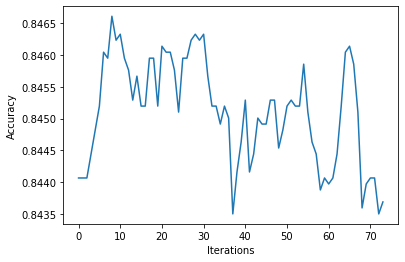

In [184]:
#iterations = range(0, 2*7 + 1, 1)
iterations = range(0,74)
plt.plot(iterations, returns)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')

In [197]:
train_py_env = LinegameEnv
eval_py_env = LinegameEnv
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### 에이전트 

In [198]:
fc_layer_params = (100,)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)
agent.initialize()

### Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this tutorial:

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

In [199]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [201]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

### Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.

정책을 평가하는 데 사용되는 가장 일반적인 메트릭은 평균 수익률입니다. 수익률은 한 에피소드에 대한 환경에서 정책을 실행하는 동안 얻은 보상의 합계입니다. 몇 개의 에피소드가 실행되어 평균 수익을 창출합니다. 다음 함수는 정책, 환경 및 에피소드 수에 따라 정책의 평균 수익률을 계산합니다.

In [212]:
returns = list()

In [213]:
returns

[]

In [214]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            print(f"{time_step.reward} 현재의 리워드다다다다다")
        total_return += episode_return
        print(f"{episode_return}이다다다ㅏ다다")
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [215]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

### new episode start! ###
 
1-1. current state = 0.1
1-2. action = -0.062
    **exit(current state<0.1) => reset current state as 0.**
1-3. reward = 0.8407655321957198
1-4. future state = 0.1
[0.] 현재의 리워드다다다다다
 
2-1. current state = 0.1
2-2. action = -0.038
    **exit(current state<0.1) => reset current state as 0.**
2-3. reward = 0.8407655321957198
2-4. future state = 0.1
[0.] 현재의 리워드다다다다다
 
3-1. current state = 0.1
3-2. action = -0.082
    **exit(current state<0.1) => reset current state as 0.**
3-3. reward = 0.8407655321957198
3-4. future state = 0.1
[0.] 현재의 리워드다다다다다
 
4-1. current state = 0.1
4-2. action = 0.0
4-3. reward = 0.8407655321957198
4-4. future state = 0.1
 
### episode ended ###
[0.84076554] 현재의 리워드다다다다다
[0.84076554]이다다다ㅏ다다
### new episode start! ###
 
1-1. current state = 0.1
1-2. action = 0.05
1-3. reward = 0.8407655321957198
1-4. future state = 0.15000000000000002
[0.] 현재의 리워드다다다다다
 
2-1. current state = 0.15000000000000002
2-2. action = 0.052
2-3. reward = 0.847082

0.845338

### Replay Buffer

The replay buffer keeps track of data collected from the environment. This tutorial uses `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.

재생 버퍼는 환경에서 수집된 데이터를 추적합니다. 이 자습서에서는 tf_agents.replay_buffers.tf_uniform_replay_buffer를 사용합니다.가장 일반적인 TFUniformReplayBuffer입니다. 생성자는 수집할 데이터에 대한 사양을 요구합니다. 이 기능은 collect_data_spec 메서드를 사용하여 에이전트에서 사용할 수 있습니다. 배치 크기와 최대 버퍼 길이도 필요합니다

In [229]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [230]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(100)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(1,), dtype=tf.int32, name='observation', minimum=array(0), maximum=array(2147483647)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [231]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

### Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [233]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=10)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

 
3-1. current state = 0.1
3-2. action = -0.056
    **exit(current state<0.1) => reset current state as 0.**
3-3. reward = 0.8407655321957198
3-4. future state = 0.1
 
4-1. current state = 0.1
4-2. action = 0.086
4-3. reward = 0.8407655321957198
4-4. future state = 0.186
 
### episode ended ###
1-1. current state = 0.1
1-2. action = -0.058
    **exit(current state<0.1) => reset current state as 0.**
1-3. reward = 0.8407655321957198
1-4. future state = 0.1
 
2-1. current state = 0.1
2-2. action = -0.038
    **exit(current state<0.1) => reset current state as 0.**
2-3. reward = 0.8407655321957198
2-4. future state = 0.1
 
3-1. current state = 0.1
3-2. action = 0.026
3-3. reward = 0.8407655321957198
3-4. future state = 0.126
 
4-1. current state = 0.126
4-2. action = 0.094
4-3. reward = 0.8438766852078816
4-4. future state = 0.22
 
### episode ended ###
1-1. current state = 0.1
1-2. action = 0.006
1-3. reward = 0.8407655321957198
1-4. future state = 0.10600000000000001
 
2-1. current stat

The replay buffer is now a collection of Trajectories.

In [220]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [234]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(2, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(2, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(2, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(2, 2, 1), dtype=tf.int32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(2, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(2, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(2, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(2,), dtype=tf.float32, name=None)))>

In [235]:
iterator = iter(dataset)

print(iterator)

In [236]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

### Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [237]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

### new episode start! ###
 
1-1. current state = 0.1
1-2. action = -0.1
    **exit(current state<0.1) => reset current state as 0.**
1-3. reward = 0.8407655321957198
1-4. future state = 0.1
[0.] 현재의 리워드다다다다다
 
2-1. current state = 0.1
2-2. action = -0.1
    **exit(current state<0.1) => reset current state as 0.**
2-3. reward = 0.8407655321957198
2-4. future state = 0.1
[0.] 현재의 리워드다다다다다
 
3-1. current state = 0.1
3-2. action = -0.1
    **exit(current state<0.1) => reset current state as 0.**
3-3. reward = 0.8407655321957198
3-4. future state = 0.1
[0.] 현재의 리워드다다다다다
 
4-1. current state = 0.1
4-2. action = -0.1
    **exit(current state<0.1) => reset current state as 0.**
4-3. reward = 0.8407655321957198
4-4. future state = 0.1
 
### episode ended ###
[0.84076554] 현재의 리워드다다다다다
[0.84076554]이다다다ㅏ다다
### new episode start! ###
 
1-1. current state = 0.1
1-2. action = -0.1
    **exit(current state<0.1) => reset current state as 0.**
1-3. reward = 0.8407655321957198
1-4. future state = 0.1
[0

 
2-1. current state = 0.1
2-2. action = 0.094
2-3. reward = 0.8407655321957198
2-4. future state = 0.194
### new episode start! ###
 
1-1. current state = 0.1
1-2. action = 0.094
1-3. reward = 0.8407655321957198
1-4. future state = 0.194
[0.] 현재의 리워드다다다다다
 
2-1. current state = 0.194
2-2. action = 0.094
2-3. reward = 0.8484019986801169
2-4. future state = 0.28800000000000003
[0.] 현재의 리워드다다다다다
 
3-1. current state = 0.28800000000000003
3-2. action = 0.094
3-3. reward = 0.849250494956161
3-4. future state = 0.382
[0.] 현재의 리워드다다다다다
 
4-1. current state = 0.382
4-2. action = 0.094
4-3. reward = 0.8489676628641463
4-4. future state = 0.476
 
### episode ended ###
[0.8489677] 현재의 리워드다다다다다
[0.8489677]이다다다ㅏ다다
### new episode start! ###
 
1-1. current state = 0.1
1-2. action = 0.094
1-3. reward = 0.8407655321957198
1-4. future state = 0.194
[0.] 현재의 리워드다다다다다
 
2-1. current state = 0.194
2-2. action = 0.094
2-3. reward = 0.8484019986801169
2-4. future state = 0.28800000000000003
[0.] 현재의 리워드다다다

### Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

In [250]:
returns

[0.84076554,
 0.8407655321957198,
 0.8407655321957198,
 0.8407655321957198,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8489677,
 0.8484019986801169,
 0.849250494956161,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8489677]

In [246]:
returns = [0.84076554,
 0.8407655321957198,
 0.8407655321957198,
 0.8407655321957198,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8489677,
 0.8484019986801169,
 0.849250494956161,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8484019986801169,
 0.849250494956161,
 0.8489676628641463,
 0.8489677]

ValueError: x and y must have same first dimension, but have shapes (3,) and (20,)

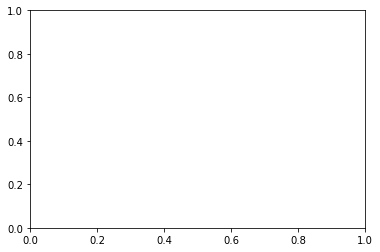

In [247]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')


Text(0.5, 0, 'Iterations')

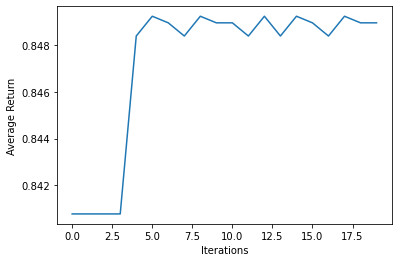

In [251]:
iterations = range(0,20)


#iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')